In [1]:
# Libraries import
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objs as go
#import plotly.express as px
from plotly.offline import init_notebook_mode

from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool, GeoJSONDataSource, LinearColorMapper

from googletrans import Translator

#import statsmodels.api as sn

import requests
import json

In [2]:
# Data import - 'Datos abiertos COVID-19 (Colombia)'
data = pd.DataFrame.from_dict(requests.get('https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=9999999999999').json())
#data

In [3]:
# Data import - 'World Health Organization (WHO) COVID-19 Global Data'
who_data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
#who_data

In [4]:
# Data import - 'Colombian Departments GeoJson'
d_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/be6a6e239cd5b5b803c6e7c2ec405b793a9064dd/Colombia.geo.json').json()
#d_geojson

In [5]:
# Data import - 'Colombian Towns & Cities GeoJson'
tc_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/727e8992e9599b9d9f1dbfdc4c8e479e/raw/090f8b935a437e24d65b64d87598fbb437c006da/colombia-municipios.json').json()
#tc_geojson

In [6]:
# Data cleaning and adjusting
translator = Translator()
translations = {}

departments = {}
towns_cities = {}
status_counts = []

data.columns = ['Id de caso', 'Fecha de notificación', 'Código DIVIPOLA', 'Ciudad de ubicación', 'Departamento', 'Estado', 'Edad', 'Sexo', 'Tipo', 'Severidad','País de procedencia', 'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web', 'Tipo de recuperación', 'Código departamento', 'Código país', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Fecha de defunción']
#who_data.columns = ['']

for element in data['País de procedencia'].unique():
    translations[element] = translator.translate(" ".join(element.split(" ")[:2])).text if type(element) !=  float else 'Colombia'

data['País de procedencia'].replace(translations, inplace=True)

for column in ['Edad', 'Código departamento', 'Código DIVIPOLA']:
    data[column] = data[column].apply(lambda x: int(x))
    
data['Clasificación de edad'] = pd.cut(x=data['Edad'], bins=[0,10,20,30,40,50,60,70,80,90,np.inf], include_lowest=True, labels=['0 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 100+'])

for column in ['Ciudad de ubicación', 'Estado', 'Sexo', 'Tipo', 'Severidad', 'País de procedencia']:
    data[column] = data[column].str.capitalize()
    
for column in ['Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de defunción', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web']:
    data[column] = data[column].str.slice(0,10).replace(r'(\d+)-(\d+)-(\d+)', r'\1-\2-\3', regex=True).apply(lambda x: pd.to_datetime(x, dayfirst=True, errors='ignore'))

for element in d_geojson['features']:
    departments[int(element['properties']['DPTO'])] = element['properties']['NOMBRE_DPT']
    
#for element in tc_geojson['geometries']:
#    towns_cities[int(element['id'])] = element['properties']['name']
    
status_counts = data['Estado'].value_counts().to_list()

date = data['Fecha de reporte web'].iloc[-1].strftime('%Y-%m-%d')
    
data = data[['Id de caso', 'Fecha de reporte web', 'Fecha de diagnóstico', 'Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de recuperación', 'Fecha de defunción', 'Ciudad de ubicación', 'Departamento', 'Severidad', 'Estado', 'Edad', 'Clasificación de edad', 'Sexo', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Tipo', 'Tipo de recuperación', 'País de procedencia', 'Código departamento', 'Código país', 'Código DIVIPOLA']]
data = data.set_index('Id de caso')

In [7]:
# Helper functions
def GetBars(df):
    d = df.to_dict('list')
    #for i in range(df[]):

def numbers(div): #x
    for i in range(0, len(ax.patches)//div, 1):
        height = 0
        for j in range(0, div, 1):
            height += ax.patches[j*(len(ax.patches)//div)+i].get_height()
        ax.text(ax.patches[i].get_x()+(ax.patches[i].get_width()/10),height+(height/100)+10, int(height), fontsize=7, color='dimgrey', rotation=90)

def numbers_H(div): #y
    for i in range(0, len(ax.patches)//div, 1):
        width = 0
        for j in range(0, div, 1):
            width += ax.patches[j*(len(ax.patches)//div)+i].get_width()
        ax.text(width+(width/100)+10,ax.patches[i].get_y()+(ax.patches[i].get_height()/10), int(width), fontsize=7, color='dimgrey', rotation=0)

In [8]:
# Testing
#bars = GetBars()

bar_chart = go.Figure(
    data = go.Histogram(
        
    ),
    layout = go.Layout(
        title="Casos confirmados VS Clasificación de Edad (Estado)",
        yaxis_title="Clasificación de edad",
        xaxis_title="Casos confirmados",
    )
)
#bar_chart.show()

#data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).to_dict('list')

In [9]:
#geosource = GeoJSONDataSource(geojson=json.dumps(d_geojson))

In [10]:
# In-line plots libraries import
%matplotlib inline
init_notebook_mode(connected = True)

# COVID-19 Status (Colombia) 🇨🇴

#### Fuente: <a href='https://datos.gov.co'>Datos Abiertos - Colombia</a>

### - Panorama nacional COVID-19 (Colombia)

In [11]:
local_map = go.Figure(go.Choropleth(
    z=data['Código departamento'].value_counts().sort_index().tolist(),
    locations=[departments[key] for key in sorted(departments.keys())],
    featureidkey='properties.NOMBRE_DPT',
    geojson=d_geojson,
    colorscale='blues',
    colorbar_title="Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

local_map.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds='locations')

local_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

local_map.show()

### - Dataset COVID-19 (Colombia)

In [12]:
data

Fecha de reporte web Fecha de diagnóstico Fecha de notificación  \
Id de caso                                                                   
1                    2020-03-06           2020-03-06            2020-03-02   
2                    2020-03-09           2020-03-09            2020-03-06   
3                    2020-03-09           2020-03-09            2020-03-07   
4                    2020-03-11           2020-03-11            2020-03-09   
5                    2020-03-11           2020-03-11            2020-03-09   
...                         ...                  ...                   ...   
728626               2020-09-15           2020-09-14            2020-09-03   
728627               2020-09-15           2020-09-08            2020-08-28   
728628               2020-09-15           2020-09-13            2020-09-02   
728629               2020-09-15           2020-09-14            2020-09-03   
728630               2020-09-15           2020-08-29            2020-08-18   

           Fecha de inicio de síntomas Fecha de recuperación  \
Id de caso                                                     
1                           2020-02-27            2020-03-13   
2                           2020-03-04            2020-03-19   
3                           2020-02-29            2020-03-15   
4                           2020-03-06            2020-03-26   
5                           2020-03-08            2020-03-23   
...                                ...                   ...   
728626                      2020-08-30                   NaT   
728627                      2020-08-24                   NaT   
728628                      2020-08-29                   NaT   
728629                      2020-08-30                   NaT   
728630                      2020-08-15                   NaT   

           Fecha de defunción  Ciudad de ubicación       Departamento  \
Id de caso                                                              
1                         NaT          Bogotá d.c.        Bogotá D.C.   
2                         NaT  Guadalajara de buga    Valle del Cauca   
3                         NaT             Medellín          Antioquia   
4                         NaT             Medellín          Antioquia   
5                         NaT             Medellín          Antioquia   
...                       ...                  ...                ...   
728626                    NaT             Medellín          Antioquia   
728627                    NaT             Medellín          Antioquia   
728628                    NaT               Cajicá       Cundinamarca   
728629                    NaT                Tuluá    Valle del Cauca   
728630                    NaT         Barranquilla  Barranquilla D.E.   

           Severidad      Estado  ...  Clasificación de edad Sexo  \
Id de caso                        ...                               
1               Leve  Recuperado  ...                10 - 20    F   
2               Leve  Recuperado  ...                30 - 40    M   
3               Leve  Recuperado  ...                40 - 50    F   
4               Leve  Recuperado  ...                50 - 60    M   
5               Leve  Recuperado  ...                20 - 30    M   
...              ...         ...  ...                    ...  ...   
728626          Leve        Casa  ...                10 - 20    M   
728627          Leve        Casa  ...                10 - 20    M   
728628          Leve        Casa  ...                10 - 20    M   
728629          Leve        Casa  ...                30 - 40    F   
728630          Leve        Casa  ...                80 - 90    M   

           Pertenecia Étnica Nombre Grupo Étnico         Tipo  \
Id de caso                                                      
1                       Otro                 NaN    Importado   
2                      Negro                 NaN    Importado   
3                       Otro                 NaN    Imp

### - Casos activos VS Ciudad de ubicación (Estado) [TOP 50]

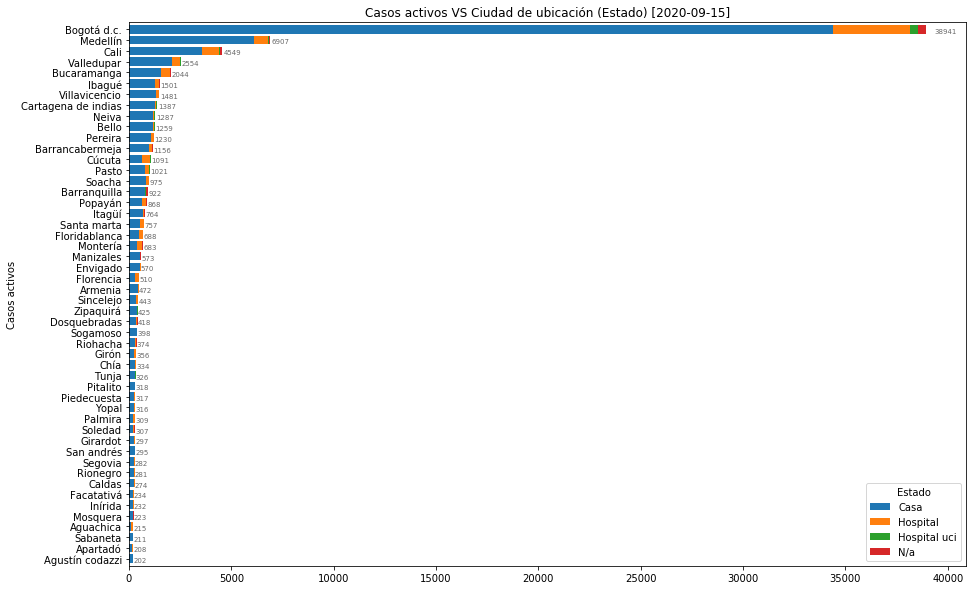

In [13]:
li = data.groupby(['Ciudad de ubicación', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').tail(50).iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos activos VS Ciudad de ubicación (Estado) [{date}]'))
ax.set_ylabel('Casos activos')
div = len(li.columns)-1
numbers_H(div)

In [14]:
li.sort_values('Total', ascending=False).head(50)

Estado                  Casa  Hospital  Hospital uci    N/a    Total
Ciudad de ubicación                                                 
Bogotá d.c.          34412.0    3749.0         368.0  412.0  38941.0
Medellín              6090.0     682.0          58.0   77.0   6907.0
Cali                  3586.0     814.0          50.0   99.0   4549.0
Valledupar            2111.0     406.0          24.0   13.0   2554.0
Bucaramanga           1573.0     425.0          27.0   19.0   2044.0
Ibagué                1278.0     185.0          15.0   23.0   1501.0
Villavicencio         1317.0     142.0           8.0   14.0   1481.0
Cartagena de indias   1291.0      53.0           5.0   38.0   1387.0
Neiva                 1180.0      59.0          40.0    8.0   1287.0
Bello                 1156.0      89.0           8.0    6.0   1259.0
Pereira               1056.0     146.0          18.0   10.0   1230.0
Barrancabermeja        974.0     168.0           8.0    6.0   1156.0
Cúcuta                 624.0     399.0          56.0   12.0   1091.0
Pasto                  779.0     212.0          14.0   16.0   1021.0
Soacha                 809.0     147.0          10.0    9.0    975.0
Barranquilla           789.0      18.0           2.0  113.0    922.0
Popayán                658.0     184.0          15.0   11.0    868.0
Itagüí                 700.0      53.0           4.0    7.0    764.0
Santa marta            551.0     178.0           9.0   19.0    757.0
Floridablanca          487.0     185.0          11.0    5.0    688.0
Montería               379.0     244.0           9.0   51.0    683.0
Manizales              517.0      44.0           2.0   10.0    573.0
Envigado               530.0      35.0           3.0    2.0    570.0
Florencia              287.0     206.0           5.0   12.0    510.0
Armenia                429.0      42.0           0.0    1.0    472.0
Sincelejo              348.0      72.0           7.0   16.0    443.0
Zipaquirá              396.0      21.0           4.0    4.0    425.0
Dosquebradas           359.0      52.0           6.0    1.0    418.0
Sogamoso               378.0      18.0           1.0    1.0    398.0
Riohacha               283.0      83.0           2.0    6.0    374.0
Girón                  255.0      93.0           4.0    4.0    356.0
Chía                   292.0      33.0           5.0    4.0    334.0
Tunja                  280.0      37.0           3.0    6.0    326.0
Pitalito               289.0      21.0           5.0    3.0    318.0
Piedecuesta            228.0      79.0           8.0    2.0    317.0
Yopal                  258.0      56.0           2.0    0.0    316.0
Palmira                204.0      95.0           3.0    7.0    309.0
Soledad                221.0      40.0           2.0   44.0    307.0
Girardot               253.0      41.0           3.0    0.0    297.0
San andrés             274.0      19.0           1.0    1.0    295.0
Segovia                271.0       8.0           3.0    0.0    282.0
Rionegro               237.0      38.0           3.0    3.0    281.0
Caldas                 258.0      16.0           0.0    0.0    274.0
Facatativá             201.0      28.0           4.0    1.0    234.0
Inírida                219.0      13.0           0.0    0.0    232.0
Mosquera               197.0      21.0           3.0    2.0    223.0
Aguachica              102.0     103.0           9.0    1.0    215.0
Sabaneta               199.0      11.0           0.0    1.0    211.0
Apartadó               156.0      45.0           2.0    5.0    208.0
Agustín codazzi        179.0      22.0           1.0    0.0    202.0

### - Casos activos VS Departamento (Estado)

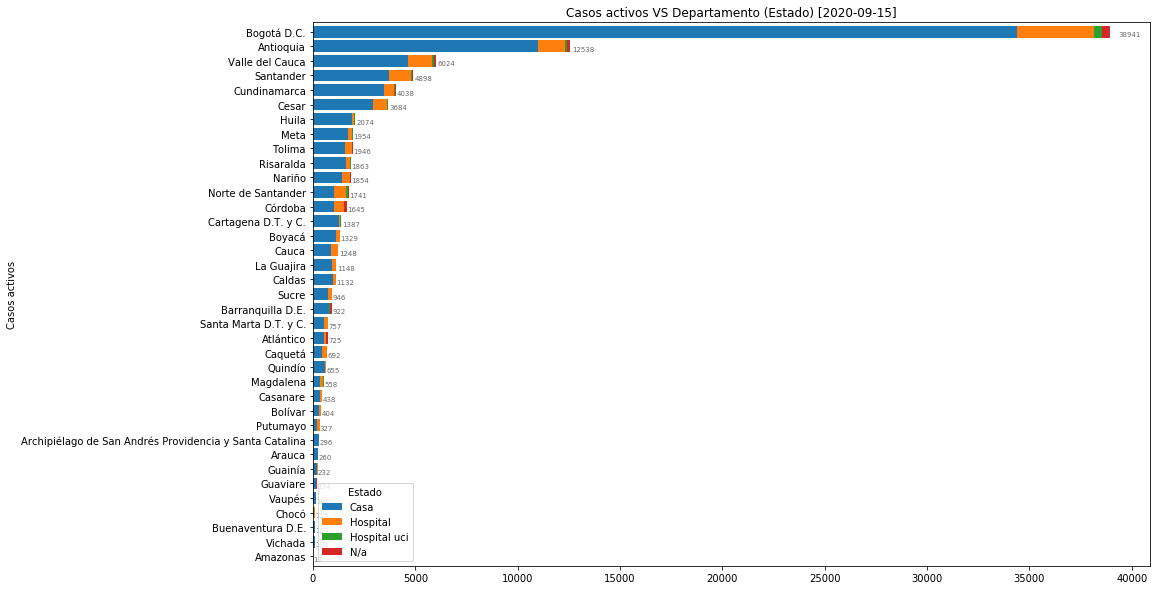

In [15]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos activos VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos activos')
div = len(li.columns)-1
numbers_H(div)

In [16]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Hospital  \
Departamento                                                            
Bogotá D.C.                                         34412.0    3749.0   
Antioquia                                           11000.0    1296.0   
Valle del Cauca                                      4660.0    1165.0   
Santander                                            3732.0    1056.0   
Cundinamarca                                         3447.0     500.0   
Cesar                                                2952.0     670.0   
Huila                                                1884.0     111.0   
Meta                                                 1689.0     235.0   
Tolima                                               1560.0     324.0   
Risaralda                                            1592.0     234.0   
Nariño                                               1407.0     389.0   
Norte de Santander                                   1012.0     610.0   
Córdoba                                              1012.0     510.0   
Cartagena D.T. y C.                                  1291.0      53.0   
Boyacá                                               1144.0     160.0   
Cauca                                                 862.0     338.0   
La Guajira                                            941.0     184.0   
Caldas                                                994.0     113.0   
Sucre                                                 727.0     182.0   
Barranquilla D.E.                                     789.0      18.0   
Santa Marta D.T. y C.                                 551.0     178.0   
Atlántico                                             535.0      89.0   
Caquetá                                               425.0     242.0   
Quindío                                               598.0      55.0   
Magdalena                                             366.0     147.0   
Casanare                                              346.0      87.0   
Bolívar                                               297.0      73.0   
Putumayo                                              174.0     148.0   
Archipiélago de San Andrés Providencia y Santa ...    275.0      19.0   
Arauca                                                227.0      30.0   
Guainía                                               219.0      13.0   
Guaviare                                              154.0      18.0   
Vaupés                                                151.0      10.0   
Chocó                                                  57.0      45.0   
Buenaventura D.E.                                      77.0      20.0   
Vichada                                                96.0       4.0   
Amazonas                                                4.0       5.0   

Estado                                              Hospital uci    N/a  \
Departamento                                                              
Bogotá D.C.                                                368.0  412.0   
Antioquia                                                   96.0  146.0   
Valle del Cauca                                             67.0  132.0   
Santander                                                   65.0   45.0   
Cundinamarca                                                50.0   41.0   
Cesar                                                       38.0   24.0   
Huila                                                       61.0   18.0   
Meta                                                        10.0   20.0   
Tolima                                                      23.0   39.0   
Risaralda                                                   24.0   13.0   
Nariño                                                      21.0   37.0   
Norte de Santander                                          95.0   24.0   
Córdoba                                                     15.0  108.0   
Cartagena D.T. y C.        

### - Recuperados y Fallecidos VS Departamento

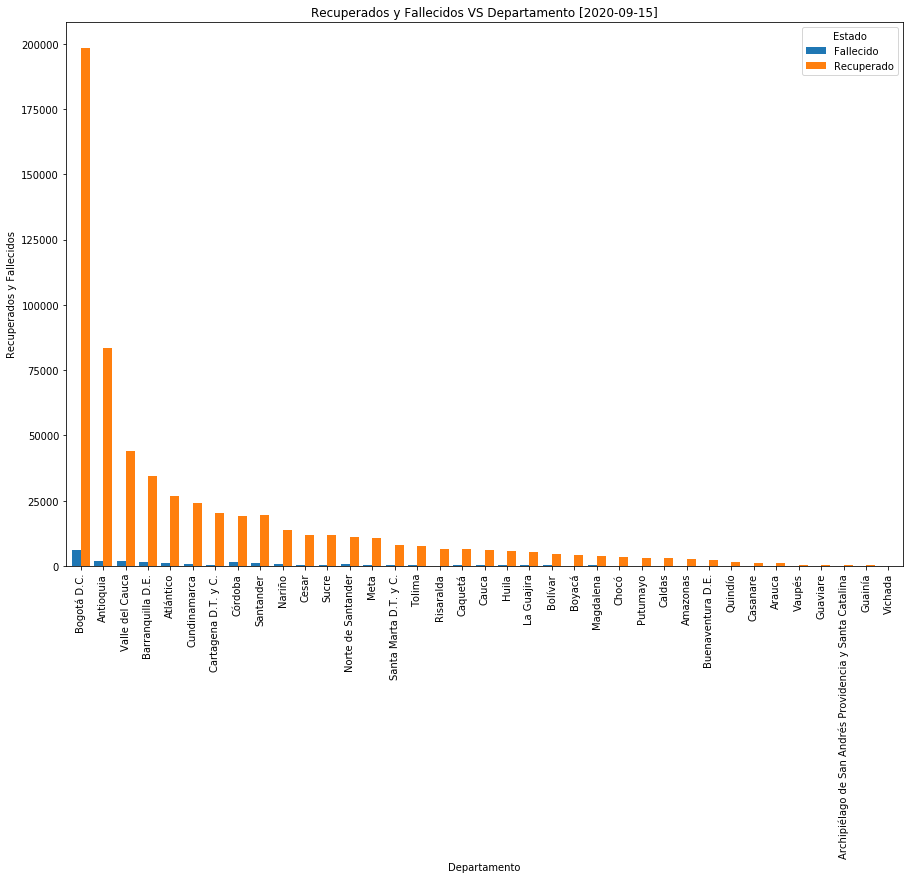

In [17]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, True, False, False, False, True]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=False, figsize=(15,10), title=(f'Recuperados y Fallecidos VS Departamento [{date}]'))
ax.set_ylabel('Recuperados y Fallecidos')
div = len(li.columns)-1
#numbers(div)

In [18]:
li.sort_values('Total', ascending=False).iloc[:,:len(li.columns)-1]

Estado                                              Fallecido  Recuperado
Departamento                                                             
Bogotá D.C.                                            6266.0    198249.0
Antioquia                                              2102.0     83422.0
Valle del Cauca                                        1877.0     43980.0
Barranquilla D.E.                                      1646.0     34667.0
Atlántico                                              1347.0     26731.0
Cundinamarca                                            845.0     24238.0
Cartagena D.T. y C.                                     537.0     20233.0
Córdoba                                                1467.0     19124.0
Santander                                              1089.0     19454.0
Nariño                                                  620.0     13842.0
Cesar                                                   448.0     11981.0
Sucre                                                   546.0     11801.0
Norte de Santander                                      800.0     11296.0
Meta                                                    338.0     10735.0
Santa Marta D.T. y C.                                   408.0      8219.0
Tolima                                                  252.0      7754.0
Risaralda                                               181.0      6617.0
Caquetá                                                 265.0      6389.0
Cauca                                                   215.0      5976.0
Huila                                                   246.0      5872.0
La Guajira                                              268.0      5448.0
Bolívar                                                 213.0      4777.0
Boyacá                                                  110.0      4091.0
Magdalena                                               367.0      3661.0
Chocó                                                   152.0      3602.0
Putumayo                                                154.0      2920.0
Caldas                                                   88.0      2971.0
Amazonas                                                115.0      2597.0
Buenaventura D.E.                                       164.0      2247.0
Quindío                                                  66.0      1434.0
Casanare                                                 36.0      1123.0
Arauca                                                   28.0      1045.0
Vaupés                                                    4.0       426.0
Guaviare                                                  6.0       338.0
Archipiélago de San Andrés Providencia y Santa ...        9.0       291.0
Guainía                                                   9.0       218.0
Vichada                                                   4.0       209.0

* Fallecimientos relacionados al COVID-19.

### - Casos confirmados VS Departamento (Estado)

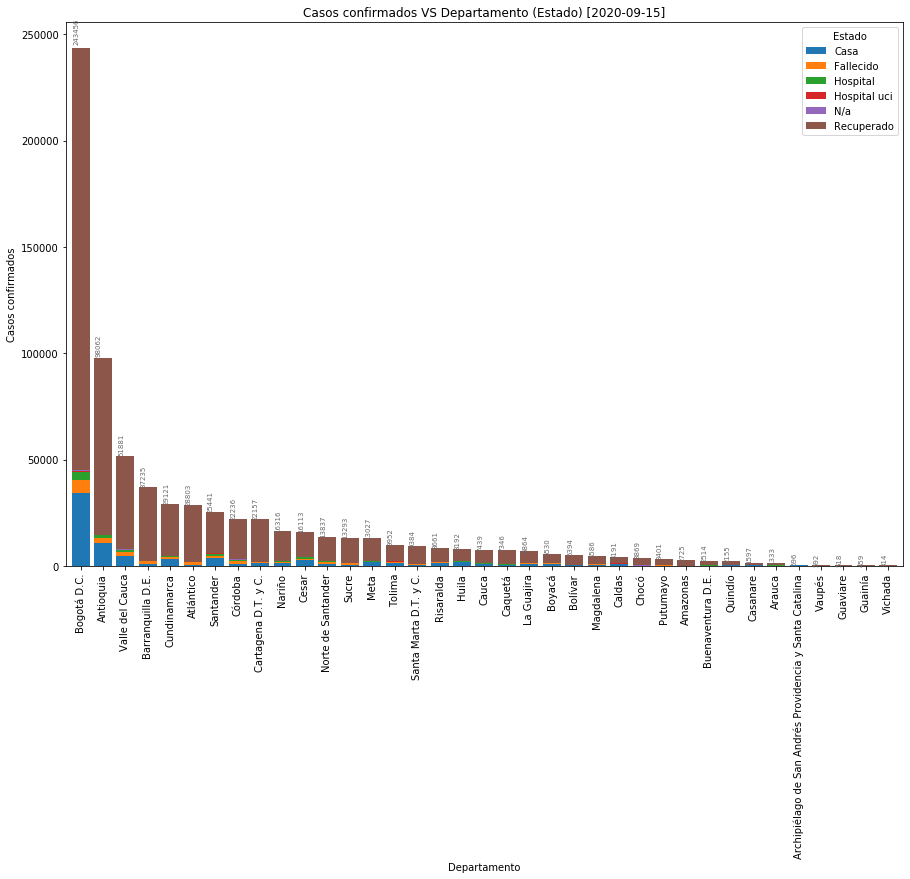

In [19]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [20]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Fallecido  \
Departamento                                                             
Bogotá D.C.                                         34412.0     6266.0   
Antioquia                                           11000.0     2102.0   
Valle del Cauca                                      4660.0     1877.0   
Barranquilla D.E.                                     789.0     1646.0   
Cundinamarca                                         3447.0      845.0   
Atlántico                                             535.0     1347.0   
Santander                                            3732.0     1089.0   
Córdoba                                              1012.0     1467.0   
Cartagena D.T. y C.                                  1291.0      537.0   
Nariño                                               1407.0      620.0   
Cesar                                                2952.0      448.0   
Norte de Santander                                   1012.0      800.0   
Sucre                                                 727.0      546.0   
Meta                                                 1689.0      338.0   
Tolima                                               1560.0      252.0   
Santa Marta D.T. y C.                                 551.0      408.0   
Risaralda                                            1592.0      181.0   
Huila                                                1884.0      246.0   
Cauca                                                 862.0      215.0   
Caquetá                                               425.0      265.0   
La Guajira                                            941.0      268.0   
Boyacá                                               1144.0      110.0   
Bolívar                                               297.0      213.0   
Magdalena                                             366.0      367.0   
Caldas                                                994.0       88.0   
Chocó                                                  57.0      152.0   
Putumayo                                              174.0      154.0   
Amazonas                                                4.0      115.0   
Buenaventura D.E.                                      77.0      164.0   
Quindío                                               598.0       66.0   
Casanare                                              346.0       36.0   
Arauca                                                227.0       28.0   
Archipiélago de San Andrés Providencia y Santa ...    275.0        9.0   
Vaupés                                                151.0        4.0   
Guaviare                                              154.0        6.0   
Guainía                                               219.0        9.0   
Vichada                                                96.0        4.0   

Estado                                              Hospital  Hospital uci  \
Departamento                                                                 
Bogotá D.C.                                           3749.0         368.0   
Antioquia                                             1296.0          96.0   
Valle del Cauca                                       1165.0          67.0   
Barranquilla D.E.                                       18.0           2.0   
Cundinamarca                                           500.0          50.0   
Atlántico                                               89.0           6.0   
Santander                                             1056.0          65.0   
Córdoba                                                510.0          15.0   
Cartagena D.T. y C.                                     53.0           5.0   
Nariño                                                 389.0          21.0   
Cesar                                                  670.0          38.0   
Norte de Santander                                     610.0          95.0   
Sucre                

### - Casos confirmados VS Departamento (Sexo)

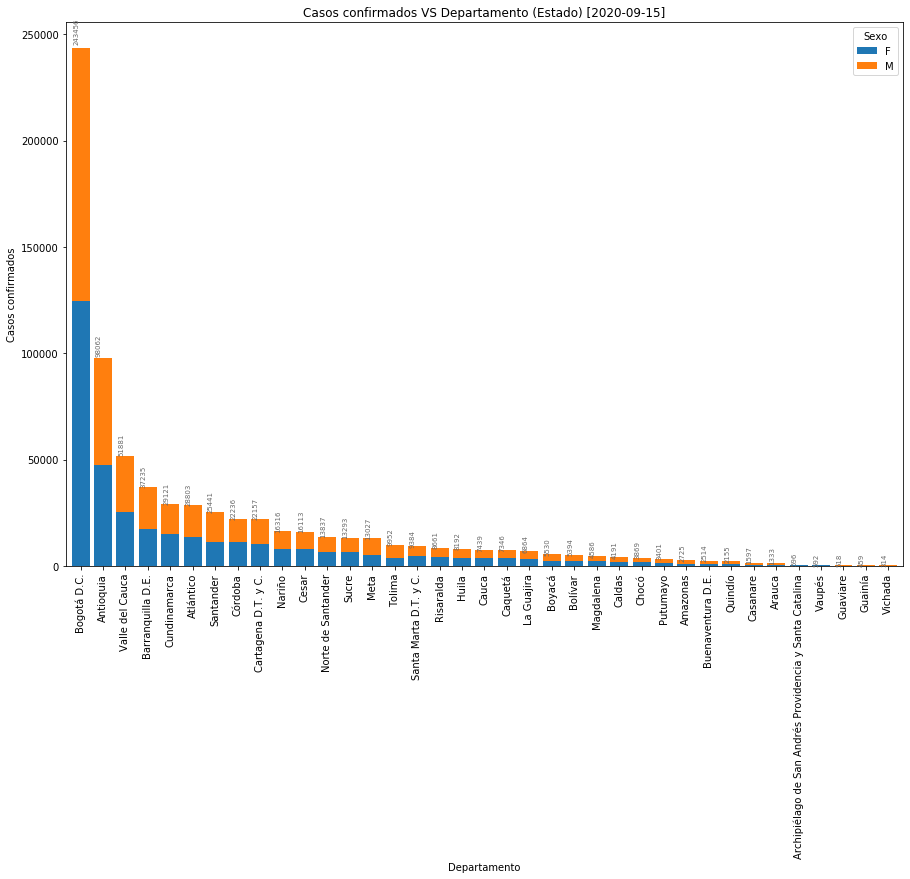

In [21]:
li = data.groupby(['Departamento', 'Sexo']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [22]:
li.sort_values('Total', ascending=False)

Sexo                                                     F       M   Total
Departamento                                                              
Bogotá D.C.                                         124547  118909  243456
Antioquia                                            47601   50461   98062
Valle del Cauca                                      25344   26537   51881
Barranquilla D.E.                                    17638   19597   37235
Cundinamarca                                         14865   14256   29121
Atlántico                                            13660   15143   28803
Santander                                            11502   13939   25441
Córdoba                                              11530   10706   22236
Cartagena D.T. y C.                                  10339   11818   22157
Nariño                                                7915    8401   16316
Cesar                                                 7889    8224   16113
Norte de Santander                                    6455    7382   13837
Sucre                                                 6565    6728   13293
Meta                                                  5251    7776   13027
Tolima                                                3972    5980    9952
Santa Marta D.T. y C.                                 4733    4651    9384
Risaralda                                             4173    4488    8661
Huila                                                 3993    4199    8192
Cauca                                                 3636    3803    7439
Caquetá                                               3625    3721    7346
La Guajira                                            3518    3346    6864
Boyacá                                                2572    2958    5530
Bolívar                                               2545    2849    5394
Magdalena                                             2337    2249    4586
Caldas                                                1999    2192    4191
Chocó                                                 1840    2029    3869
Putumayo                                              1582    1819    3401
Amazonas                                              1177    1548    2725
Buenaventura D.E.                                      919    1595    2514
Quindío                                               1075    1080    2155
Casanare                                               678     919    1597
Arauca                                                 494     839    1333
Archipiélago de San Andrés Providencia y Santa ...     307     289     596
Vaupés                                                 262     330     592
Guaviare                                               181     337     518
Guainía                                                203     256     459
Vichada                                                 96     218     314

### - Mapa de influencia COVID-19 (Colombia)

In [23]:
global_map = go.Figure(data = go.Choropleth(
    z = data['País de procedencia'].value_counts().sort_index().tolist(),
    locations = sorted(data['País de procedencia'].unique().tolist()),
    locationmode = 'country names',
    colorscale = 'greens',
    colorbar_title = "Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

global_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

global_map.show()

### - Casos confirmados acumulado VS Fecha de diagnóstico (Estado)

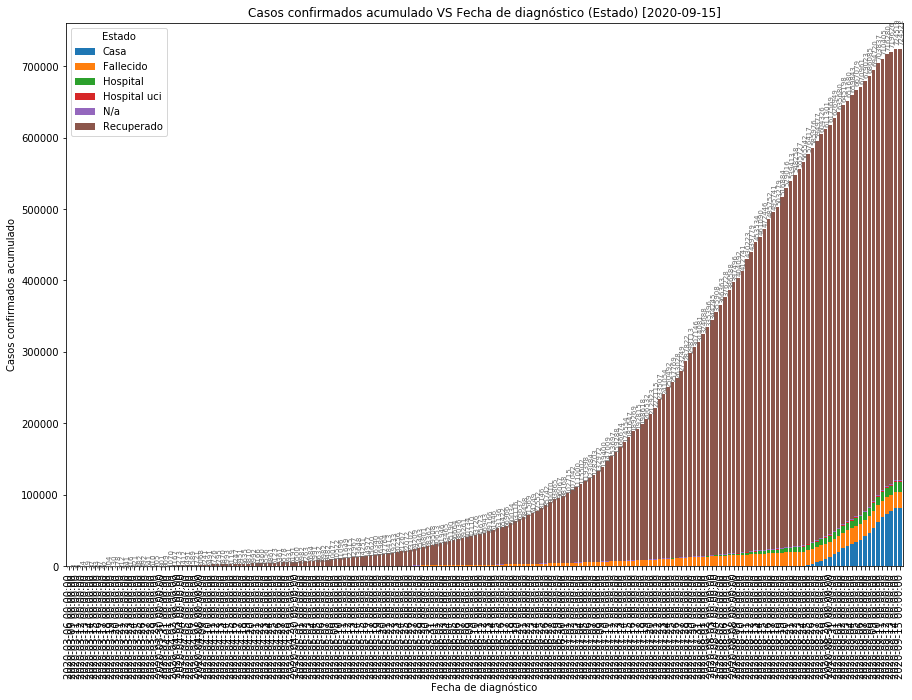

In [24]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulado VS Fecha de diagnóstico (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Estado'].unique())
numbers(div)

In [25]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Estado                   Casa  Fallecido  Hospital  Hospital uci     N/a  \
Fecha de diagnóstico                                                       
2020-09-15            81587.0    23079.0   13074.0        1045.0  1511.0   
2020-09-14            81585.0    23079.0   13074.0        1044.0  1511.0   
2020-09-13            76984.0    23079.0   12801.0        1026.0  1511.0   
2020-09-12            73812.0    23068.0   12660.0        1016.0  1510.0   
2020-09-11            68398.0    23026.0   12396.0        1009.0  1505.0   
2020-09-10            62365.0    22962.0   12101.0        1001.0  1502.0   
2020-09-09            54263.0    22885.0   11682.0         988.0  1496.0   
2020-09-08            46991.0    22786.0   11284.0         981.0  1491.0   
2020-09-07            41788.0    22700.0   10985.0         966.0  1488.0   
2020-09-06            36554.0    22590.0   10681.0         937.0  1480.0   
2020-09-05            34343.0    22533.0   10516.0         919.0  1479.0   
2020-09-04            31223.0    22421.0   10096.0         889.0  1475.0   
2020-09-03            28369.0    22310.0    9890.0         850.0  1466.0   
2020-09-02            25091.0    22198.0    9654.0         826.0  1460.0   
2020-09-01            20670.0    21958.0    9413.0         782.0  1447.0   
2020-08-31            16638.0    21794.0    9192.0         759.0  1443.0   
2020-08-30            12360.0    21601.0    8876.0         719.0  1435.0   
2020-08-29            10031.0    21478.0    8645.0         682.0  1422.0   
2020-08-28             7871.0    21317.0    8406.0         652.0  1416.0   
2020-08-27             5548.0    21084.0    8022.0         606.0  1411.0   
2020-08-26             3539.0    20852.0    7706.0         581.0  1399.0   
2020-08-25             2007.0    20564.0    7395.0         550.0  1387.0   
2020-08-24               44.0    20313.0    7085.0         514.0  1374.0   
2020-08-23               39.0    20023.0    6764.0         479.0  1357.0   
2020-08-22               38.0    19848.0    6530.0         466.0  1350.0   
2020-08-21               37.0    19583.0    6163.0         459.0  1338.0   
2020-08-20               36.0    19291.0    5784.0         433.0  1316.0   
2020-08-19               32.0    18856.0    5291.0         393.0  1299.0   
2020-08-18               30.0    18512.0    4874.0         352.0  1280.0   
2020-08-17               28.0    18248.0    4623.0         343.0  1256.0   
2020-08-16               27.0    18039.0    4385.0         326.0  1242.0   
2020-08-15               27.0    17724.0    4047.0         301.0  1229.0   
2020-08-14               26.0    17414.0    3710.0         282.0  1219.0   
2020-08-13               24.0    17161.0    3499.0         271.0  1208.0   
2020-08-12               18.0    16829.0    3133.0         253.0  1187.0   
2020-08-11               17.0    16450.0    2810.0         232.0  1174.0   
2020-08-10               17.0    16019.0    2308.0         195.0  1148.0   
2020-08-09               16.0    15783.0    2047.0         177.0  1128.0   
2020-08-08                9.0    15550.0    1826.0         164.0  1120.0   
2020-08-07                9.0    15208.0    1598.0         143.0  1099.0   
2020-08-06                9.0    14903.0    1343.0         107.0  1076.0   
2020-08-05                8.0    14605.0    1123.0          78.0  1052.0   
2020-08-04                7.0    14302.0     851.0          52.0  1025.0   
2020-08-03                7.0    13961.0     583.0          22.0  1005.0   
2020-08-02                7.0    13609.0     336.0          11.0   983.0   
2020-08-01                7.0    13232.0     281.0           6.0   967.0   
2020-07-31                7.0    12877.0     249.0           5.0   944.0   
2020-07-30                7.0    12630.0     216.0           5.0   927.0   
2020-07-29                7.0    12329.0     195.0           5.0   905.0   
2020-07-28                7.0    12025.0     175.0           5.0   879.0   
2020-07-27                6.0    11460.0     160

### - Casos confirmados VS Fecha de diagnóstico (Estado)

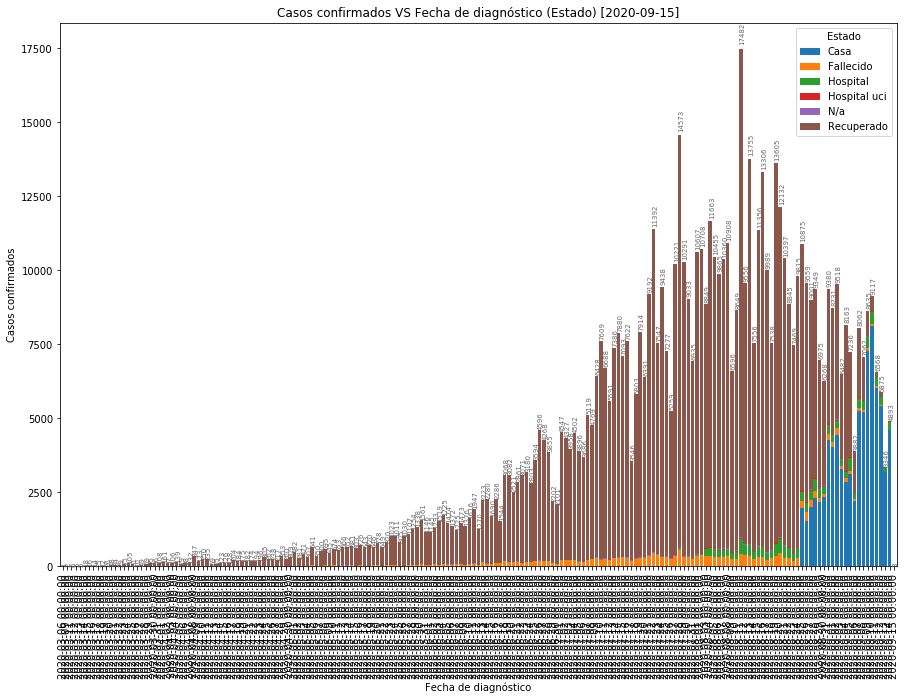

In [26]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers(div)

In [27]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).tail(60)[::-1]

Estado                  Casa  Fallecido  Hospital  Hospital uci   N/a  \
Fecha de diagnóstico                                                    
2020-09-15               2.0        0.0       0.0           1.0   0.0   
2020-09-14            4601.0        0.0     273.0          18.0   0.0   
2020-09-13            3172.0       11.0     141.0          10.0   1.0   
2020-09-12            5414.0       42.0     264.0           7.0   5.0   
2020-09-11            6033.0       64.0     295.0           8.0   3.0   
2020-09-10            8102.0       77.0     419.0          13.0   6.0   
2020-09-09            7272.0       99.0     398.0           7.0   5.0   
2020-09-08            5203.0       86.0     299.0          15.0   3.0   
2020-09-07            5234.0      110.0     304.0          29.0   8.0   
2020-09-06            2211.0       57.0     165.0          18.0   1.0   
2020-09-05            3120.0      112.0     420.0          30.0   4.0   
2020-09-04            2854.0      111.0     206.0          39.0   9.0   
2020-09-03            3278.0      112.0     236.0          24.0   6.0   
2020-09-02            4421.0      240.0     241.0          44.0  13.0   
2020-09-01            4032.0      164.0     221.0          23.0   4.0   
2020-08-31            4278.0      193.0     316.0          40.0   8.0   
2020-08-30            2329.0      123.0     231.0          37.0  13.0   
2020-08-29            2160.0      161.0     239.0          30.0   6.0   
2020-08-28            2323.0      233.0     384.0          46.0   5.0   
2020-08-27            2009.0      232.0     316.0          25.0  12.0   
2020-08-26            1532.0      288.0     311.0          31.0  12.0   
2020-08-25            1963.0      251.0     310.0          36.0  13.0   
2020-08-24               5.0      290.0     321.0          35.0  17.0   
2020-08-23               1.0      175.0     234.0          13.0   7.0   
2020-08-22               1.0      265.0     367.0           7.0  12.0   
2020-08-21               1.0      292.0     379.0          26.0  22.0   
2020-08-20               4.0      435.0     493.0          40.0  17.0   
2020-08-19               2.0      344.0     417.0          41.0  19.0   
2020-08-18               2.0      264.0     251.0           9.0  24.0   
2020-08-17               1.0      209.0     238.0          17.0  14.0   
2020-08-16               0.0      315.0     338.0          25.0  13.0   
2020-08-15               1.0      310.0     337.0          19.0  10.0   
2020-08-14               2.0      253.0     211.0          11.0  11.0   
2020-08-13               6.0      332.0     366.0          18.0  21.0   
2020-08-12               1.0      379.0     323.0          21.0  13.0   
2020-08-11               0.0      431.0     502.0          37.0  26.0   
2020-08-10               1.0      236.0     261.0          18.0  20.0   
2020-08-09               7.0      233.0     221.0          13.0   8.0   
2020-08-08               0.0      342.0     228.0          21.0  21.0   
2020-08-07               0.0      305.0     255.0          36.0  23.0   
2020-08-06               1.0      298.0     220.0          29.0  24.0   
2020-08-05               1.0      303.0     272.0          26.0  27.0   
2020-08-04               0.0      341.0     268.0          30.0  20.0   
2020-08-03               0.0      352.0     247.0          11.0  22.0   
2020-08-02               0.0      377.0      55.0           5.0  16.0   
2020-08-01               0.0      355.0      32.0           1.0  23.0   
2020-07-31               0.0      247.0      33.0           0.0  17.0   
2020-07-30               0.0      301.0      21.0           0.0  22.0   
2020-07-29               0.0      304.0      20.0           0.0  26.0   
2020-07-28               1.0      565.0      15.0           1.0  46.0   
2020-07-27               0.0      337.0      26.0           0.0  25.0   
2020-07-26               0.0      251.0       7.0           0.0  14.0   
2020-07-25               0.0      310.0      12.0         

### - Casos confirmados VS Clasificación de edad (Estado)

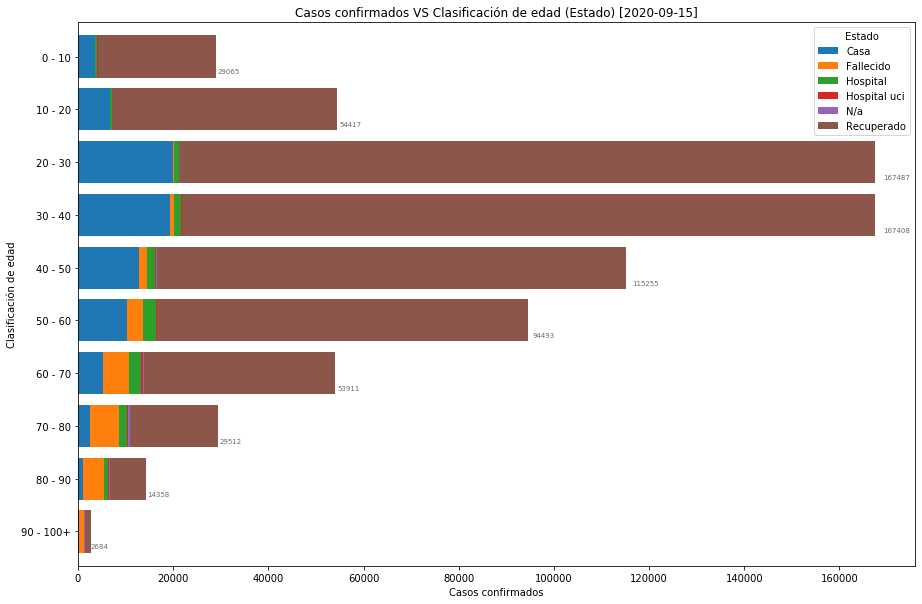

In [28]:
ax = data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Clasificación de edad (Estado) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers_H(div)

In [29]:
data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0)

Estado                  Casa  Fallecido  Hospital  Hospital uci  N/a  \
Clasificación de edad                                                  
0 - 10                  3515         35       557            14   34   
10 - 20                 6699         38       355            13   29   
20 - 30                19898        294      1043            37   63   
30 - 40                19431        752      1519            95   58   
40 - 50                12865       1650      1771           129  112   
50 - 60                10268       3465      2568           229  180   
60 - 70                 5188       5596      2527           264  328   
70 - 80                 2521       6003      1745           200  363   
80 - 90                 1055       4445       878            64  299   
90 - 100+                219       1010       117             3   71   

Estado                 Recuperado  
Clasificación de edad              
0 - 10                      24910  
10 - 20                     47283  
20 - 30                    146152  
30 - 40                    145553  
40 - 50                     98728  
50 - 60                     77783  
60 - 70                     40008  
70 - 80                     18680  
80 - 90                      7617  
90 - 100+                    1264

### - Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)

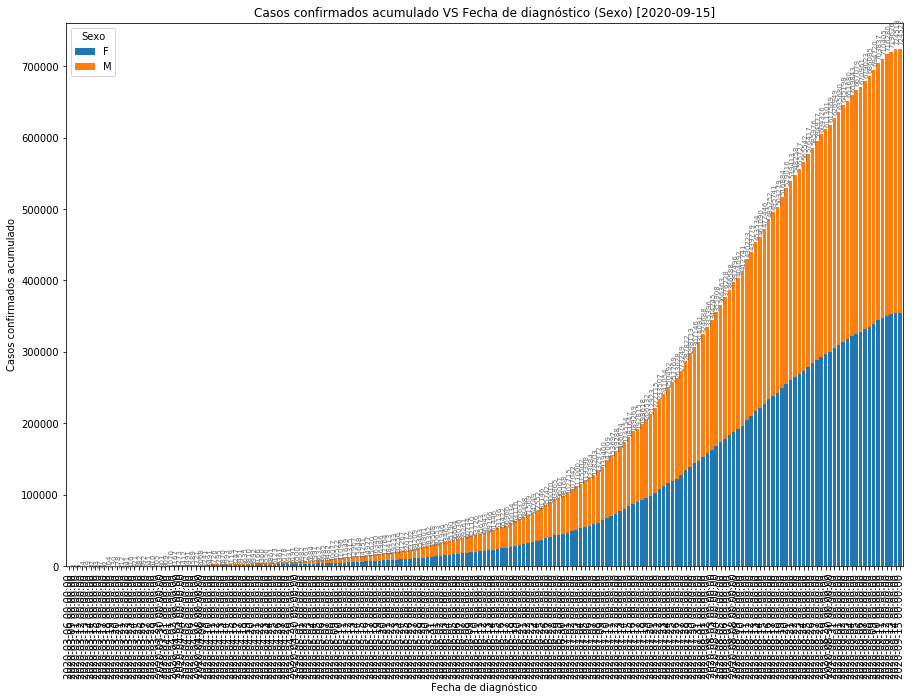

In [30]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulado VS Fecha de diagnóstico (Sexo) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Sexo'].unique())
numbers(div)

In [31]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Sexo                         F         M
Fecha de diagnóstico                    
2020-09-15            355077.0  369445.0
2020-09-14            355076.0  369443.0
2020-09-13            352584.0  367042.0
2020-09-12            350879.0  365401.0
2020-09-11            347758.0  362647.0
2020-09-10            344245.0  359592.0
2020-09-09            339580.0  355140.0
2020-09-08            335170.0  350915.0
2020-09-07            331555.0  347468.0
2020-09-06            327372.0  343589.0
2020-09-05            325382.0  341697.0
2020-09-04            321956.0  337887.0
2020-09-03            317563.0  334117.0
2020-09-02            314251.0  330947.0
2020-09-01            309391.0  326289.0
2020-08-31            305013.0  321936.0
2020-08-30            300074.0  317495.0
2020-08-29            296899.0  314402.0
2020-08-28            293365.0  310961.0
2020-08-27            288672.0  306305.0
2020-08-26            284127.0  301849.0
2020-08-25            279254.0  297163.0
2020-08-24            273796.0  291746.0
2020-08-23            268907.0  286820.0
2020-08-22            265127.0  283131.0
2020-08-21            260957.0  278456.0
2020-08-20            255716.0  273300.0
2020-08-19            249604.0  267280.0
2020-08-18            242510.0  260769.0
2020-08-17            238868.0  256873.0
2020-08-16            233593.0  252159.0
2020-08-15            226639.0  245807.0
2020-08-14            220870.0  240220.0
2020-08-13            217000.0  236534.0
2020-08-12            210124.0  229655.0
2020-08-11            205391.0  224832.0
2020-08-10            196332.0  216409.0
2020-08-09            191992.0  212100.0
2020-08-08            188588.0  208908.0
2020-08-07            183280.0  203308.0
2020-08-06            178219.0  198009.0
2020-08-05            173336.0  193027.0
2020-08-04            168104.0  187804.0
2020-08-03            162251.0  181994.0
2020-08-02            157971.0  177425.0
2020-08-01            152498.0  172190.0
2020-07-31            147366.0  166715.0
2020-07-30            143894.0  163252.0
2020-07-29            139499.0  158614.0
2020-07-28            134401.0  153421.0
2020-07-27            127309.0  145940.0
2020-07-26            122420.0  140608.0
2020-07-25            120009.0  137760.0
2020-07-24            116336.0  134156.0
2020-07-23            111973.0  129081.0
2020-07-22            108409.0  125098.0
2020-07-21            103265.0  118850.0
2020-07-20             98962.0  113961.0
2020-07-19             95980.0  110552.0
2020-07-18             92196.0  106422.0

### - Casos confirmados VS Fecha de diagnóstico (Sexo)

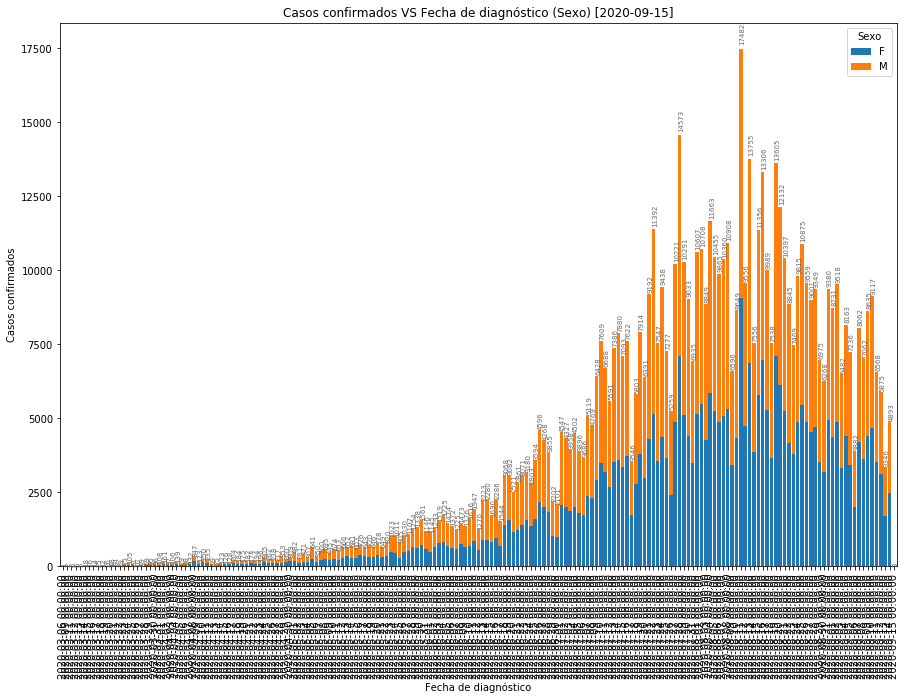

In [32]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Sexo) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers(div)

In [33]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).tail(60)[::-1]

Sexo                       F       M
Fecha de diagnóstico                
2020-09-15               1.0     2.0
2020-09-14            2492.0  2401.0
2020-09-13            1705.0  1641.0
2020-09-12            3121.0  2754.0
2020-09-11            3513.0  3055.0
2020-09-10            4665.0  4452.0
2020-09-09            4410.0  4225.0
2020-09-08            3615.0  3447.0
2020-09-07            4183.0  3879.0
2020-09-06            1990.0  1892.0
2020-09-05            3426.0  3810.0
2020-09-04            4393.0  3770.0
2020-09-03            3312.0  3170.0
2020-09-02            4860.0  4658.0
2020-09-01            4378.0  4353.0
2020-08-31            4939.0  4441.0
2020-08-30            3175.0  3093.0
2020-08-29            3534.0  3441.0
2020-08-28            4693.0  4656.0
2020-08-27            4545.0  4456.0
2020-08-26            4873.0  4686.0
2020-08-25            5458.0  5417.0
2020-08-24            4889.0  4926.0
2020-08-23            3780.0  3689.0
2020-08-22            4170.0  4675.0
2020-08-21            5241.0  5156.0
2020-08-20            6112.0  6020.0
2020-08-19            7094.0  6511.0
2020-08-18            3642.0  3896.0
2020-08-17            5275.0  4714.0
2020-08-16            6954.0  6352.0
2020-08-15            5769.0  5587.0
2020-08-14            3870.0  3686.0
2020-08-13            6876.0  6879.0
2020-08-12            4733.0  4823.0
2020-08-11            9059.0  8423.0
2020-08-10            4340.0  4309.0
2020-08-09            3404.0  3192.0
2020-08-08            5308.0  5600.0
2020-08-07            5061.0  5299.0
2020-08-06            4883.0  4982.0
2020-08-05            5232.0  5223.0
2020-08-04            5853.0  5810.0
2020-08-03            4280.0  4569.0
2020-08-02            5473.0  5235.0
2020-08-01            5132.0  5475.0
2020-07-31            3472.0  3463.0
2020-07-30            4395.0  4638.0
2020-07-29            5098.0  5193.0
2020-07-28            7092.0  7481.0
2020-07-27            4889.0  5332.0
2020-07-26            2411.0  2848.0
2020-07-25            3673.0  3604.0
2020-07-24            4363.0  5075.0
2020-07-23            3564.0  3983.0
2020-07-22            5144.0  6248.0
2020-07-21            4303.0  4889.0
2020-07-20            2982.0  3409.0
2020-07-19            3784.0  4130.0
2020-07-18            2772.0  3031.0

### - Casos confirmados VS Clasificación de edad (Sexo)

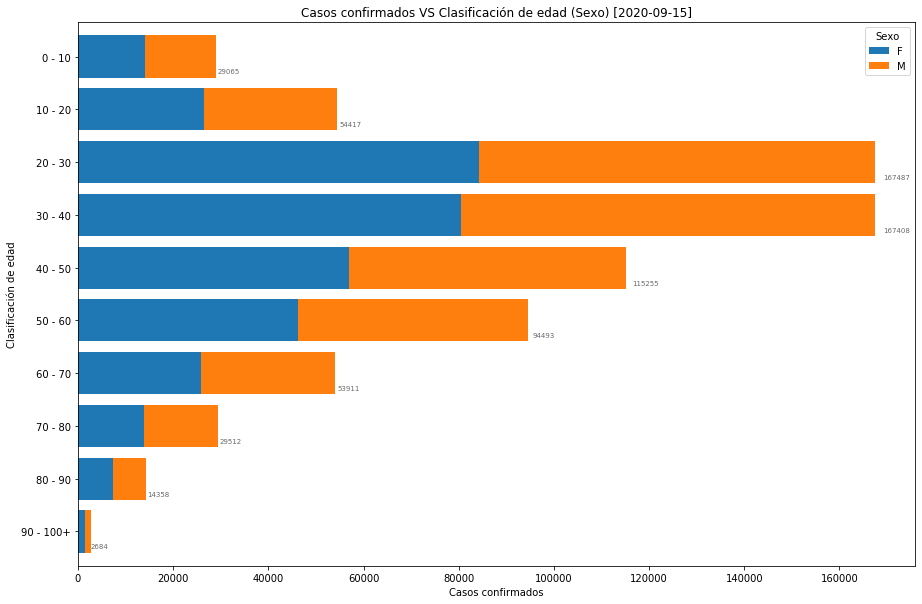

In [34]:
ax = data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Clasificación de edad (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [35]:
data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0)

Sexo                       F      M
Clasificación de edad              
0 - 10                 14179  14886
10 - 20                26432  27985
20 - 30                84168  83319
30 - 40                80520  86888
40 - 50                56863  58392
50 - 60                46234  48259
60 - 70                25934  27977
70 - 80                13810  15702
80 - 90                 7350   7008
90 - 100+               1528   1156

### - Casos confirmados VS Estado (Sexo)

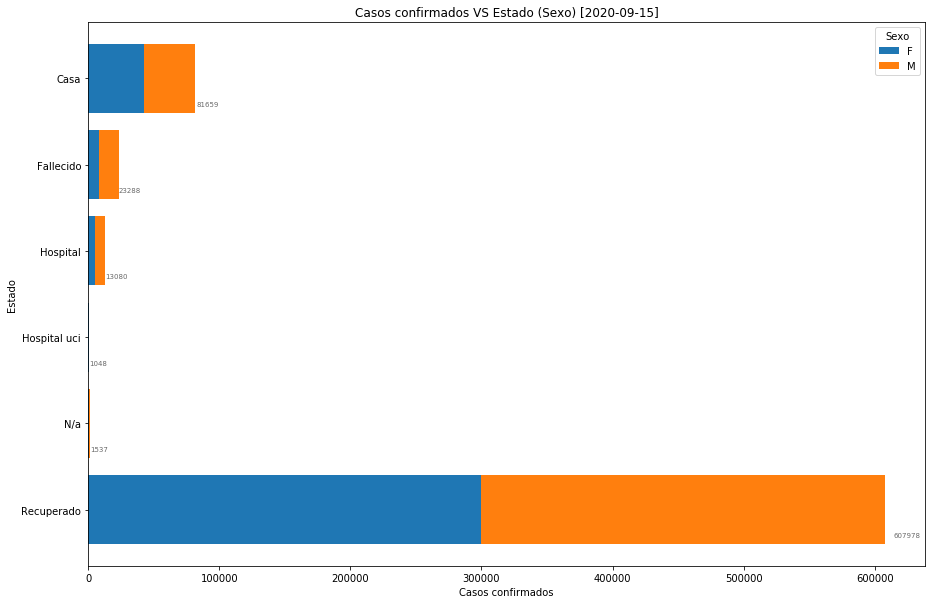

In [36]:
ax = data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Estado (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [37]:
data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0)

Sexo               F       M
Estado                      
Casa           42609   39050
Fallecido       8342   14946
Hospital        5621    7459
Hospital uci     361     687
N/a              662     875
Recuperado    299423  308555

### - Casos confirmados VS Tipo de contagio (Sexo)

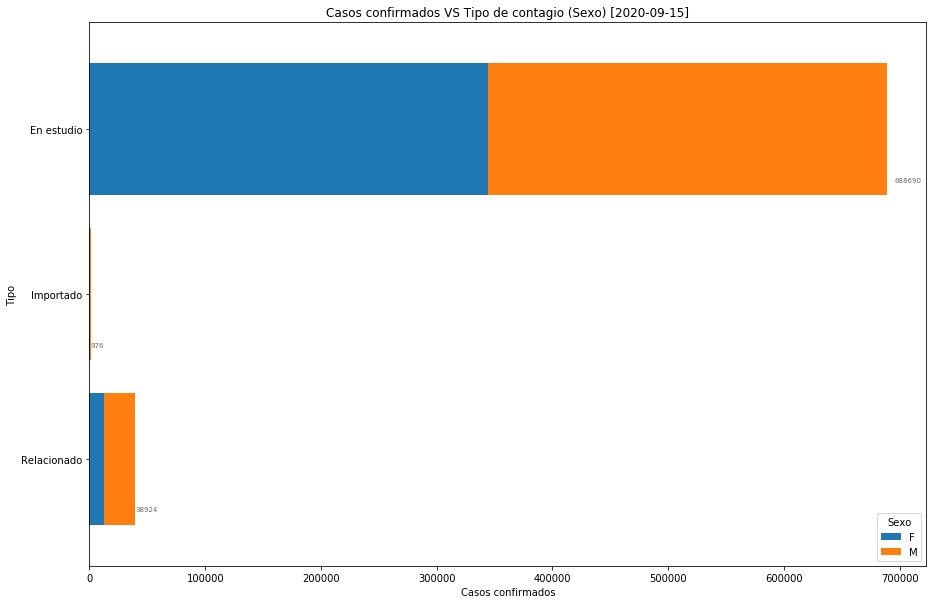

In [38]:
ax = data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Tipo de contagio (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [39]:
data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0)

Sexo              F       M
Tipo                       
En estudio   343947  344743
Importado       462     514
Relacionado   12609   26315

### - Casos confirmados acumulado VS Fecha de diagnóstico (Clasificación de edad)

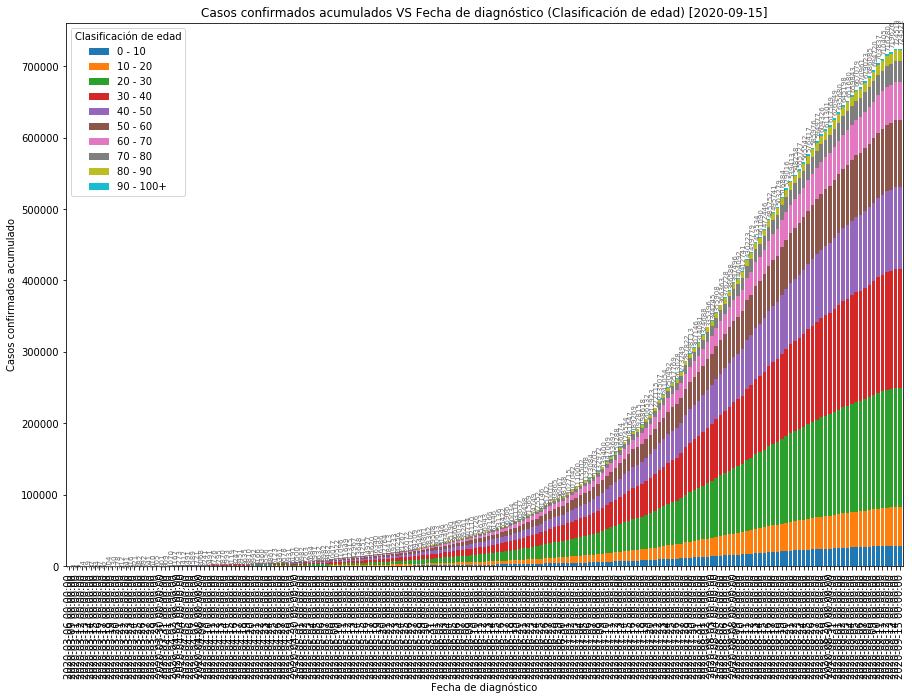

In [40]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulados VS Fecha de diagnóstico (Clasificación de edad) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [41]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-09-15              28929    54121   166492   166424   114657    93999   
2020-09-14              28929    54121   166491   166424   114657    93998   
2020-09-13              28742    53796   165410   165272   113897    93374   
2020-09-12              28625    53576   164587   164470   113396    92944   
2020-09-11              28389    53036   163224   163215   112456    92212   
2020-09-10              28174    52624   162118   161712   111248    91143   
2020-09-09              27805    51917   159775   159558   109964    90041   
2020-09-08              27500    51289   157722   157471   108593    88921   
2020-09-07              27247    50759   156137   155852   107511    88024   
2020-09-06              26947    50155   154324   154061   106211    86964   
2020-09-05              26812    49878   153465   153169   105595    86477   
2020-09-04              26539    49226   151790   151520   104475    85589   
2020-09-03              26221    48697   149879   149658   103188    84504   
2020-09-02              25989    48212   148349   148193   102144    83640   
2020-09-01              25615    47554   146218   146076   100663    82385   
2020-08-31              25276    46869   144194   144087    99313    81244   
2020-08-30              24863    46152   141948   141993    97826    80091   
2020-08-29              24622    45679   140467   140578    96839    79290   
2020-08-28              24369    45151   138836   139048    95755    78337   
2020-08-27              24053    44515   136737   136850    94277    77078   
2020-08-26              23699    43859   134640   134790    92836    75922   
2020-08-25              23353    43138   132578   132614    91290    74724   
2020-08-24              22965    42424   130108   130056    89532    73276   
2020-08-23              22603    41701   127829   127839    87991    72009   
2020-08-22              22296    41093   126049   126099    86886    71025   
2020-08-21              21978    40427   124009   123996    85554    69905   
2020-08-20              21556    39675   121537   121631    83909    68541   
2020-08-19              21078    38806   118870   118907    81984    66921   
2020-08-18              20451    37805   115819   115871    79745    65191   
2020-08-17              20204    37282   114141   114171    78543    64159   
2020-08-16              19700    36512   111925   112070    76949    62820   
2020-08-15              19089    35369   108965   109172    74832    61069   
2020-08-14              18603    34518   106350   106662    73042    59541   
2020-08-13              18351    33972   104615   104982    71826    58477   
2020-08-12              17740    32895   101500   101868    69628    56665   
2020-08-11              17396    32252    99409    99658    68113    55394   
2020-08-10              16603    30977    95282    95617    65276    53147   
2020-08-09              16283    30285    93329    93610    63921    52032   
2020-08-08              16038    29852    91811    92172    62834    51142   
2020-08-07              15623    29059    89353    89513    61116    49711   
2020-08-06              15215    28280    86989    87073    59467    48365   
2020-08-05              14768    27531    84796    84818    57882    47082   
2020-08-04              14351    26793    82394    82393    56189    45710   
2020-08-03              13865    25965    79717    79666    54267    44126   
2020-08-02              13544    25352    77710    77612    52916    42903   
2020-08-01              13109    24625    75296    75216    51107    41399   
2020-07-31              12700    23765    72735    72700    49484    40049   
2020-07-30              12432    23293    71196    71054    48305    39189   
2020-07-29              12106    22562    69002    68914    46970    38006   
2020-07-28            

### - Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)

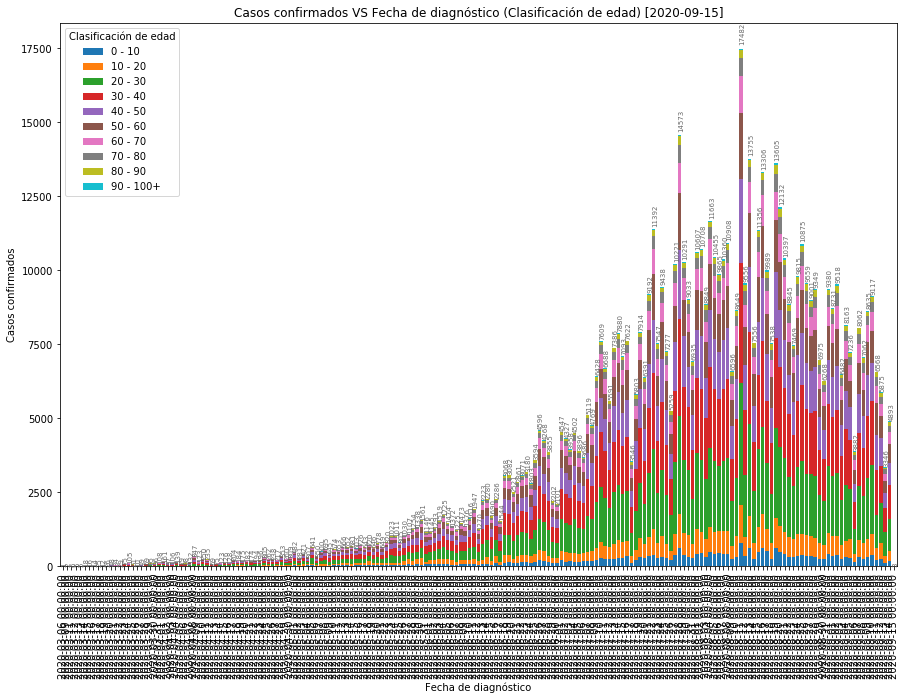

In [42]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Clasificación de edad) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [43]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-09-15                  0        0        1        0        0        1   
2020-09-14                187      325     1081     1152      760      624   
2020-09-13                117      220      823      802      501      430   
2020-09-12                236      540     1363     1255      940      732   
2020-09-11                215      412     1106     1503     1208     1069   
2020-09-10                369      707     2343     2154     1284     1102   
2020-09-09                305      628     2053     2087     1371     1120   
2020-09-08                253      530     1585     1619     1082      897   
2020-09-07                300      604     1813     1791     1300     1060   
2020-09-06                135      277      859      892      616      487   
2020-09-05                273      652     1675     1649     1120      888   
2020-09-04                318      529     1911     1862     1287     1085   
2020-09-03                232      485     1530     1465     1044      864   
2020-09-02                374      658     2131     2117     1481     1255   
2020-09-01                339      685     2024     1989     1350     1141   
2020-08-31                413      717     2246     2094     1487     1153   
2020-08-30                241      473     1481     1415      987      801   
2020-08-29                253      528     1631     1530     1084      953   
2020-08-28                316      636     2099     2198     1478     1259   
2020-08-27                354      656     2097     2060     1441     1156   
2020-08-26                346      721     2062     2176     1546     1198   
2020-08-25                388      714     2470     2558     1758     1448   
2020-08-24                362      723     2279     2217     1541     1267   
2020-08-23                307      608     1780     1740     1105      984   
2020-08-22                318      666     2040     2103     1332     1120   
2020-08-21                422      752     2472     2365     1645     1364   
2020-08-20                478      869     2667     2724     1925     1620   
2020-08-19                627     1001     3051     3036     2239     1730   
2020-08-18                247      523     1678     1700     1202     1032   
2020-08-17                504      770     2216     2101     1594     1339   
2020-08-16                611     1143     2960     2898     2117     1751   
2020-08-15                486      851     2615     2510     1790     1528   
2020-08-14                252      546     1735     1680     1216     1064   
2020-08-13                611     1077     3115     3114     2198     1812   
2020-08-12                344      643     2091     2210     1515     1271   
2020-08-11                793     1275     4127     4041     2837     2247   
2020-08-10                320      692     1953     2007     1355     1115   
2020-08-09                245      433     1518     1438     1087      890   
2020-08-08                415      793     2458     2659     1718     1431   
2020-08-07                408      779     2364     2440     1649     1346   
2020-08-06                447      749     2193     2255     1585     1283   
2020-08-05                417      738     2402     2425     1693     1372   
2020-08-04                486      828     2677     2727     1922     1584   
2020-08-03                321      613     2007     2054     1351     1223   
2020-08-02                435      727     2414     2396     1809     1504   
2020-08-01                409      860     2561     2516     1623     1350   
2020-07-31                268      472     1539     1646     1179      860   
2020-07-30                326      731     2194     2140     1335     1183   
2020-07-29                379      757     2439     2488     1699     1246   
2020-07-28            

### - Casos confirmados VS Estado (Clasificación de edad)

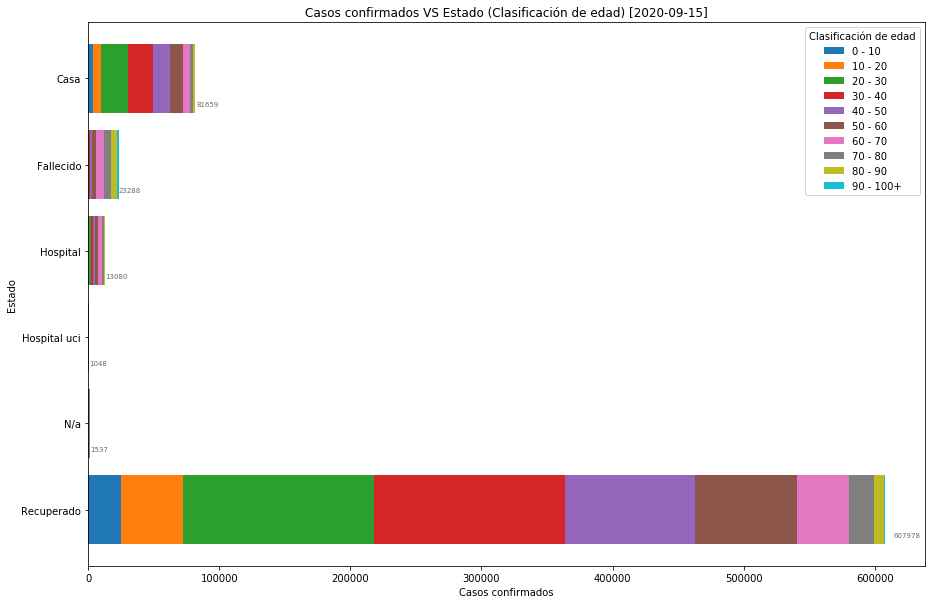

In [44]:
ax = data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Estado (Clasificación de edad) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [45]:
data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Estado                                                                       
Casa                     3515     6699    19898    19431    12865    10268   
Fallecido                  35       38      294      752     1650     3465   
Hospital                  557      355     1043     1519     1771     2568   
Hospital uci               14       13       37       95      129      229   
N/a                        34       29       63       58      112      180   
Recuperado              24910    47283   146152   145553    98728    77783   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Estado                                                       
Casa                      5188     2521     1055        219  
Fallecido                 5596     6003     4445       1010  
Hospital                  2527     1745      878        117  
Hospital uci               264      200       64          3  
N/a                        328      363      299         71  
Recuperado               40008    18680     7617       1264

### - Casos confirmados VS Tipo de contagio (Clasificación de edad)

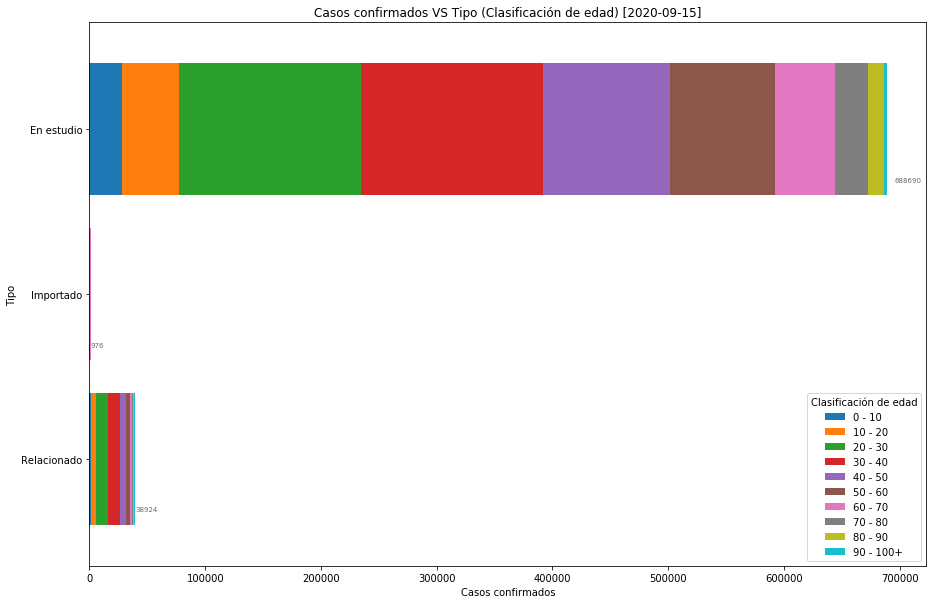

In [46]:
ax = data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Tipo (Clasificación de edad) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [47]:
data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Tipo                                                                         
En estudio              27777    49914   156689   157355   110063    90746   
Importado                   7       37      241      224      173      147   
Relacionado              1281     4466    10557     9829     5019     3600   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Tipo                                                         
En estudio               51825    28377    13508       2436  
Importado                   99       37       10          1  
Relacionado               1987     1098      840        247

## #StayHome 🏠 #QuédateEnCasa
## #WearMask 😷 #UsaMascarilla 

### Creado con ❤️ por <a href='https://github.com/jlcadavid'>@jlcadavid</a>

In [48]:
# Data storage
data.to_csv(f'./Datasets/COVID-19 Status (Colombia) [{date}].csv', index = True)